## Ejercicio Time Series Forecast
Para este ejercicio vamos a predecir cuál será la demanda de pasajeros de una aerolinea, para poder anticiparse a las contrataciones de personal, mantenimiento de las aeronaves y gestión de inventario y comidas.

Para ello, se pide:
1. Carga datos (AirPassengers.csv) y representa la serie. ¿Hay seasonality? ¿Cada cuanto?
2. Crea en una gráfica la variable original + su media obtenida mediante una rolling window con el valor de seasonality obtenido en el apartado anterior. Tienes que usar la función rolling() del DataFrame.
3. Comprueba de manera estadística si la serie es o no stationary.
4. Aplica una transformación logarítmica sobre los datos para mejorar el proceso de transformación de tu time series a stationary. Acuérdate después del forecast de invertir la transformación.
5. Divide en train y test. Guarda 20 muestras para test.
6. Crea tu primer modelo ARIMA. Habrá varias combinaciones en función de sus hiperparámetros... Mide el MAE y RMSE del modelo en predicción. Ten en cuenta el parámetro "m" de la función ARIMA, mediante el cual se establece el seasonality.
7. Representa en una gráfica los datos de test y tus predicciones.
8. Prueba un decission tree y un random forest, a ver qué performance presentan.

## 1. Carga datos y representa la serie

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Cargamos los datos
df = pd.read_csv('Data/AirPassengers.csv')

# Vemos el dataset
df

,date,value
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


In [3]:
# Convertimos la columna 'date' a formato datetime

df['date'] = pd.to_datetime(df['date'])

In [4]:
# Ponemos la columna 'date' como índice (así se comporta como serie temporal)
df.set_index('date', inplace=True)

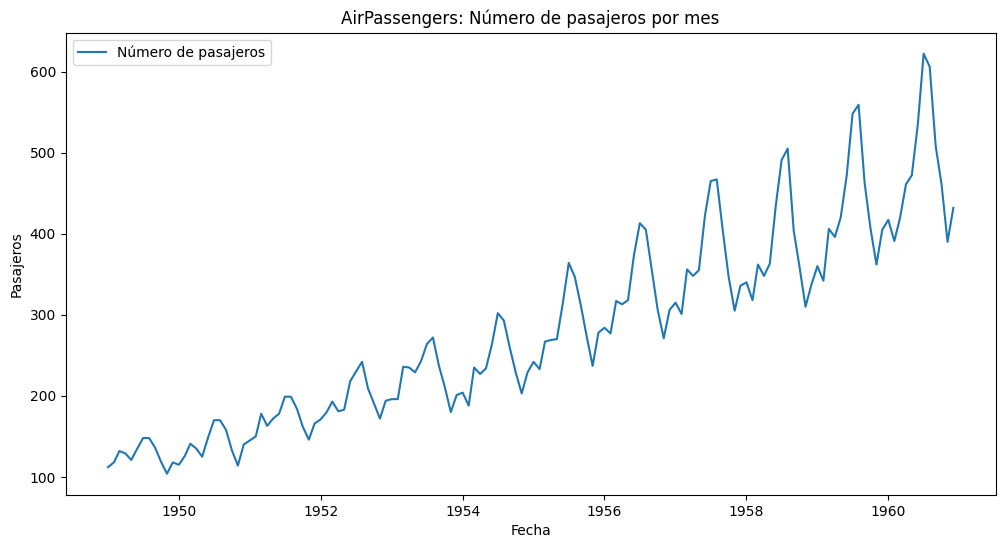

In [5]:
# Graficamos
plt.figure(figsize=(12,6))
plt.plot(df, label='Número de pasajeros')
plt.xlabel('Fecha')
plt.ylabel('Pasajeros')
plt.title('AirPassengers: Número de pasajeros por mes')
plt.legend()
plt.show()


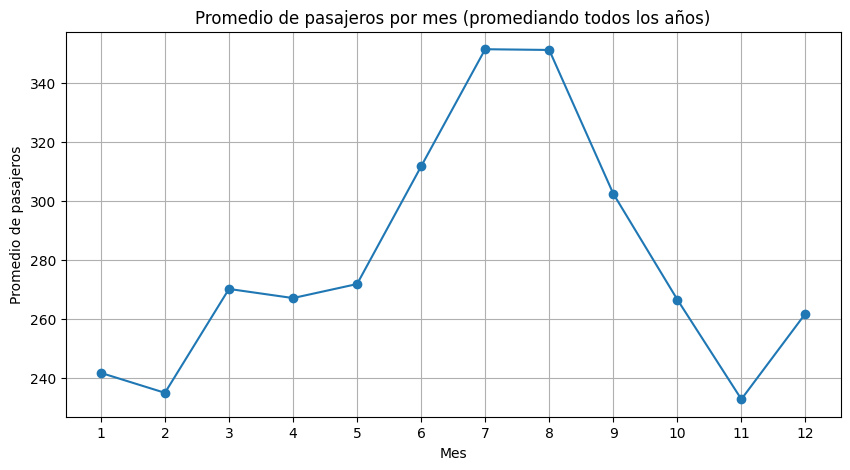

In [6]:
''' 
Vamos a destripar "date" en columnas year, month, day

Así podemos agrupar por month y calcular la media de pasajeros en ese mes para todos los años.

'''

# Creamos columnas de año y mes
df['year'] = df.index.year
df['month'] = df.index.month

# Calculamos la media de pasajeros para cada mes (promedio de todos los años)
monthly_avg = df.groupby('month')['value'].mean()

# Graficamos
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(monthly_avg.index, monthly_avg.values, marker='o')
plt.xticks(range(1,13))
plt.xlabel('Mes')
plt.ylabel('Promedio de pasajeros')
plt.title('Promedio de pasajeros por mes (promediando todos los años)')
plt.grid(True)
plt.show()


C:\Users\fer_r\AppData\Local\Temp\ipykernel_1404\2565308426.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(pivot_df.columns))


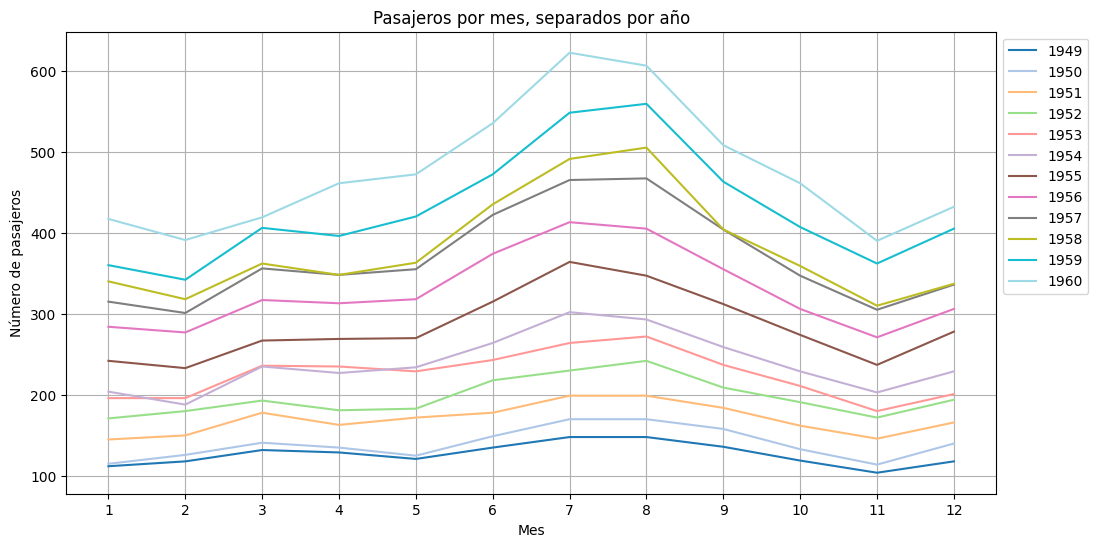

In [7]:
''' 
Hacemos un groupby por año y ver la evolución mes a mes dentro de cada año.
Esto nos permite comparar curvas anuales.
'''

# Pivotamos la tabla: rows = month, columns = year
pivot_df = df.pivot_table(values='value', index='month', columns='year')

# Usamos un colormap con más variedad
cmap = plt.cm.get_cmap('tab20', len(pivot_df.columns))

# Graficamos cada año como una línea
plt.figure(figsize=(12,6))

for idx, year in enumerate(pivot_df.columns):
    plt.plot(pivot_df.index, pivot_df[year], label=str(year), color=cmap(idx))

plt.xlabel('Mes')
plt.ylabel('Número de pasajeros')
plt.title('Pasajeros por mes, separados por año')
plt.xticks(range(1,13))
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.grid(True)
plt.show()


##### ***Vemos una clara estacionalidad en los meses 6-7-8 y un descenso en los meses 2-11.***

##### ***Se produce cada 12 meses, por lo que vemos que la estacionalidad es anual, con la diferencia de que parece que cada año viaja mas gente.***

## 2. Crea en una gráfica la variable original + su media obtenida mediante una rolling window comparando el valor de seasonality obtenido en el apartado anterior

In [8]:
# Calculamos el rolling window de 12 meses
df['rolling_mean'] = df['value'].rolling(window=12).mean()

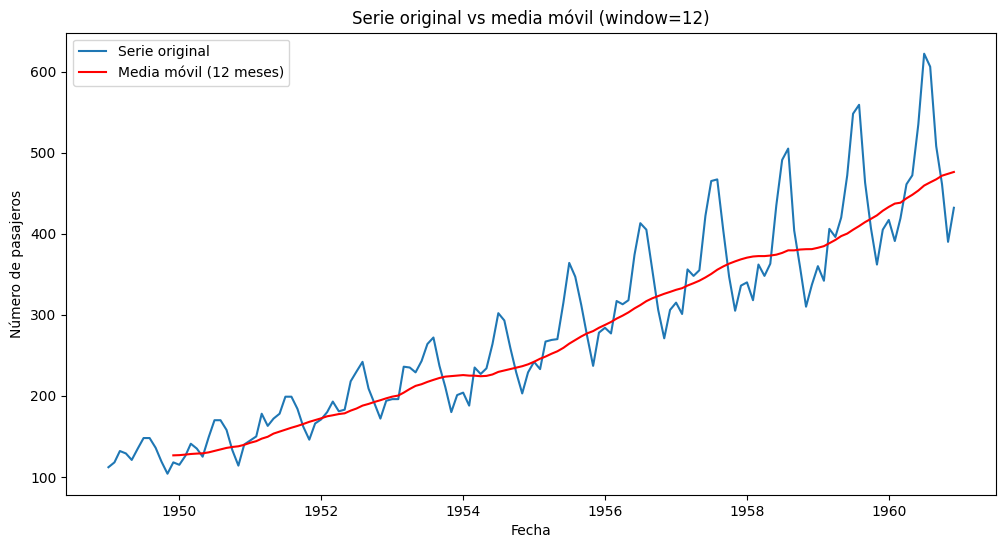

In [9]:
# Graficamos serie original + rolling mean
plt.figure(figsize=(12,6))
plt.plot(df['value'], label='Serie original')
plt.plot(df['rolling_mean'], label='Media móvil (12 meses)', color='red')

plt.xlabel('Fecha')
plt.ylabel('Número de pasajeros')
plt.title('Serie original vs media móvil (window=12)')
plt.legend()
plt.show()


## 3. Comprueba de manera estadística si la serie es o no stationary.

In [10]:
from statsmodels.tsa.stattools import adfuller, kpss
df = pd.read_csv('data/AirPassengers.csv', parse_dates=['date'])

result = adfuller(df['value'].values)
result[1]

0.991880243437641

## 4. Aplica una transformación logarítmica

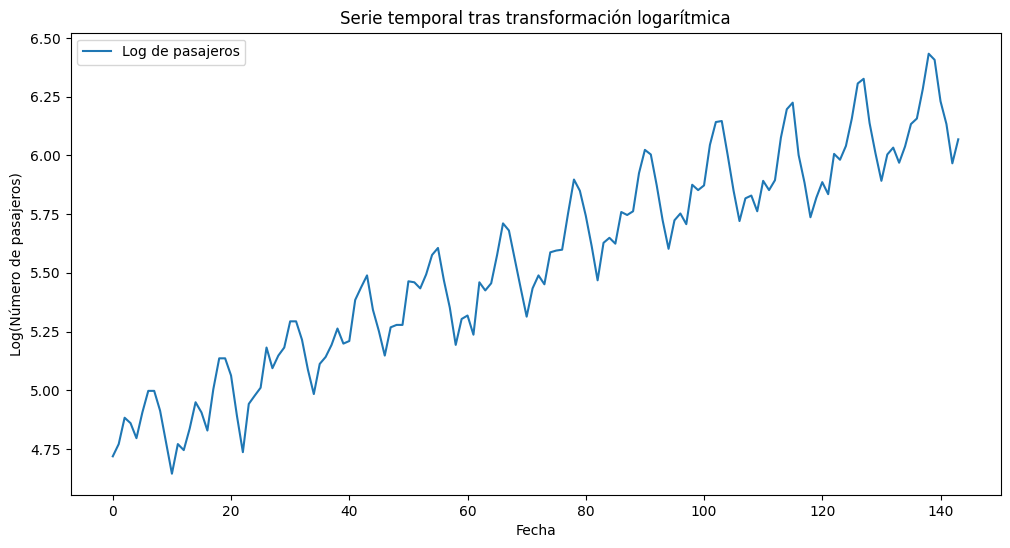

In [11]:
# Aplicamos logaritmo
df['log_value'] = np.log(df['value'])

# Graficamos la serie logarítmica
plt.figure(figsize=(12,6))
plt.plot(df['log_value'], label='Log de pasajeros')
plt.xlabel('Fecha')
plt.ylabel('Log(Número de pasajeros)')
plt.title('Serie temporal tras transformación logarítmica')
plt.legend()
plt.show()

## 5. Divide en train y test. Guarda 20 muestras para test.

In [12]:
# Dividimos en train y test
train = df['log_value'][:-20]
test = df['log_value'][-20:]

# Revisamos tamaños
print(f'Tamaño train: {len(train)}')
print(f'Tamaño test: {len(test)}')




Tamaño train: 124
Tamaño test: 20


## 6. Crea tu primer modelo ARIMA

In [13]:
from pmdarima.arima import auto_arima
from pmdarima.arima import ARIMA

model_basic = ARIMA(order=(1,0,0))
model_basic.fit(train)

c:\Users\fer_r\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


ARIMA(order=(1, 0, 0))

In [14]:
from sklearn.metrics import mean_squared_error

predictions = model_basic.predict(n_periods=20)
print("mean_squared_error:", mean_squared_error(test, predictions))

mean_squared_error: 0.1122517363415904


c:\Users\fer_r\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [19]:
import itertools
p=d=q=range(0,5)
pdq = list(itertools.product(p,d,q))
pdq[:10]

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (0, 0, 4),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4)]

In [20]:
len(pdq)

125

In [30]:
results = []
for param in pdq:
    try:
        model_arima = ARIMA(order=param)
        model_arima_fit = model_arima.fit(train)
        results.append((param,model_arima_fit.aic()))
    except:
        continue

In [22]:
resultados_df = pd.DataFrame(results, columns=['ARIMA params', 'AIC']).sort_values('AIC')
resultados_df.head()

,ARIMA params,AIC
108,"(4, 1, 3)",-253.947019
84,"(3, 1, 4)",-245.923278
59,"(2, 1, 4)",-240.928873
109,"(4, 1, 4)",-239.813200
9,"(0, 1, 4)",-237.990119


In [23]:
best_model = ARIMA(order=(4,1,3))
best_model.fit(train)

c:\Users\fer_r\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\fer_r\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(order=(4, 1, 3))

In [ ]:
predictions = best_model.predict(20)
print("mean_squared_error:", mean_squared_error(test, predictions))

mean_squared_error: 0.02610632808056144


c:\Users\fer_r\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [29]:
import warnings
warnings.filterwarnings('ignore')

model = auto_arima(train,
                   start_p = 0,
                   start_q = 0,
                   max_p = 4,
                   max_q = 4,
                   max_d = 4,
                   trace=True,
                   )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-201.351, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-202.849, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-204.251, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-202.180, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-208.997, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-204.379, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-225.736, Time=0.24 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-229.538, Time=0.39 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-228.988, Time=0.19 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-233.966, Time=0.27 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-214.822, Time=0.25 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, T

## 7. Representa en una gráfica los datos de test y tus predicciones.

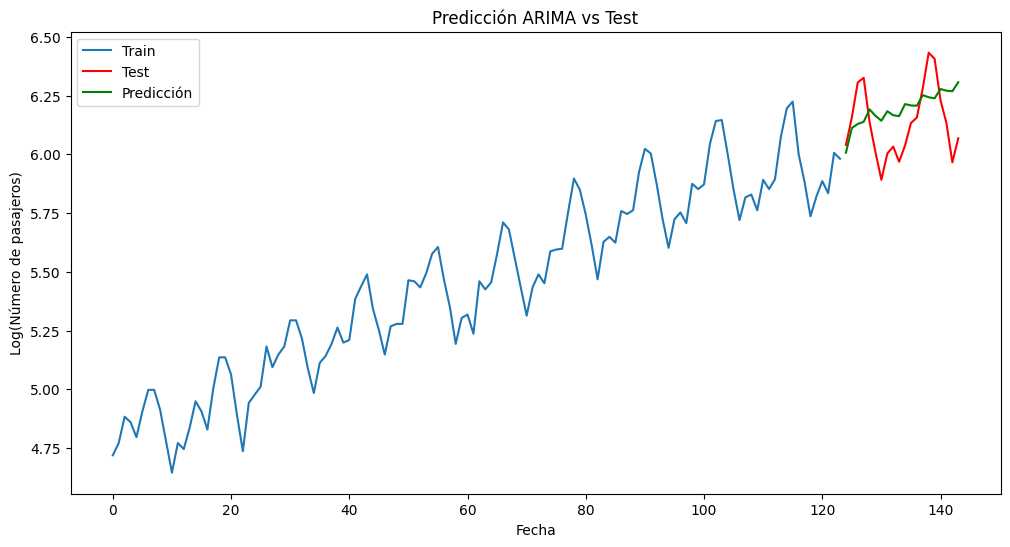

In [31]:
predictions = best_model.predict(n_periods=20)

# ✅ Graficamos
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='red')
plt.plot(test.index, predictions, label='Predicción', color='green')

plt.xlabel('Fecha')
plt.ylabel('Log(Número de pasajeros)')
plt.title('Predicción ARIMA vs Test')
plt.legend()
plt.show()


## 8. Prueba otros modelos, a ver qué performance presentan.

In [32]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Definimos SARIMA usando el best_model de ARIMA (4,1,3) + seasonal_order
model_sarima = SARIMAX(train,
                       order=(4,1,3),           # Best ARIMA params
                       seasonal_order=(1,1,1,12), # Primera prueba estacional
                       enforce_stationarity=False,
                       enforce_invertibility=False)

# Entrenamos
model_sarima_fit = model_sarima.fit(disp=False)

# Predecimos las 20 muestras de test
pred_sarima = model_sarima_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

# Calculamos error
from sklearn.metrics import mean_squared_error
print("SARIMA MSE:", mean_squared_error(test, pred_sarima))


SARIMA MSE: 0.002376090625706593
